In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:29]) == "AOI_4_Shanghai"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img4094.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img506.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img1874.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img1456.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img7054.tif')]

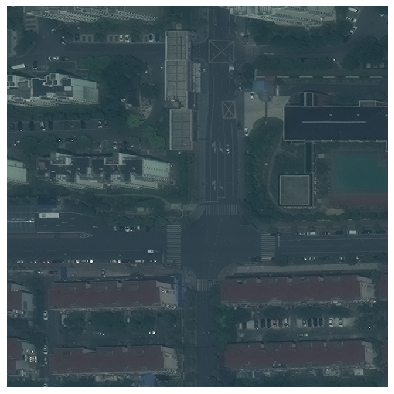

In [6]:
img = open_image(fname[11])
img.show(figsize=(7,7))

In [7]:
# string = 'Images/'
# data = [string + x.name for x in fname]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Shanghai_buildings.csv")

In [5]:
shanghai_df = pd.read_csv(path/'Shanghai_buildings.csv')
shanghai_df = shanghai_df.drop(columns = 'Unnamed: 0')
shanghai_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_4_Shanghai_img4094.tif
1,Images/RGB-PanSharpen_AOI_4_Shanghai_img506.tif
2,Images/RGB-PanSharpen_AOI_4_Shanghai_img1874.tif
3,Images/RGB-PanSharpen_AOI_4_Shanghai_img1456.tif
4,Images/RGB-PanSharpen_AOI_4_Shanghai_img7054.tif


In [6]:
len(shanghai_df)

4582

In [7]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [8]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [9]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(shanghai_df, path).
      split_by_rand_pct(.10).
      label_from_func(get_y_fn, classes=codes))

In [13]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.3, max_lighting = 0.5), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

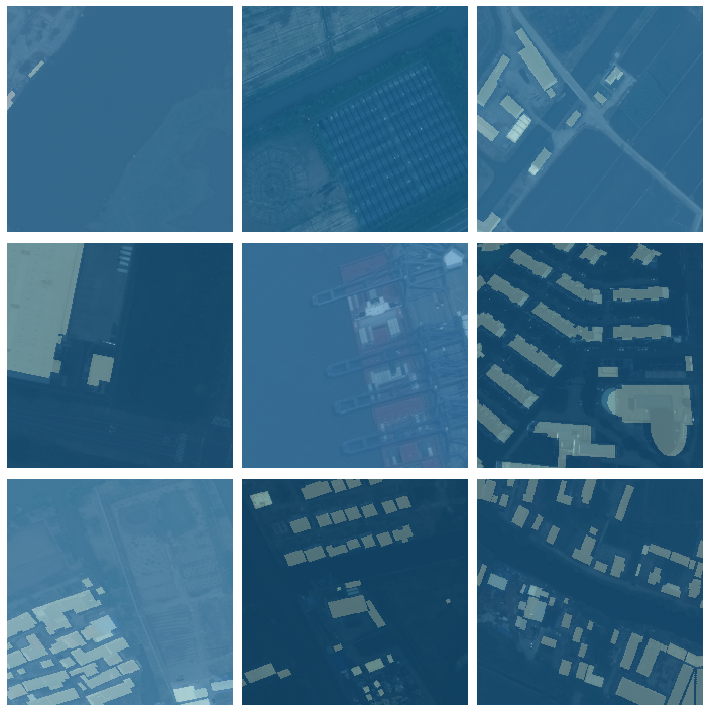

In [14]:
data.show_batch(3, figsize=(10,10))

In [15]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight, 
                     self_attention = True)
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


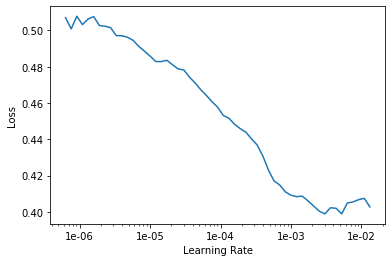

In [16]:
learn.lr_find()
learn.recorder.plot() 

In [17]:
learn.fit_one_cycle(5, slice(5e-4))

epoch,train_loss,valid_loss,dice,time
0,0.266128,0.202592,0.350997,00:58
1,0.205560,0.170678,0.533509,00:56
2,0.180966,0.163636,0.578799,00:56
3,0.163160,0.143311,0.591416,00:56
4,0.150351,0.140681,0.602128,00:56


In [18]:
save_model(learn, 'Shanghai', 'F', 'smol', 1)

# Start Recording

In [10]:
import wandb
from wandb.fastai import WandbCallback

In [20]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [21]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Shanghai.ipynb"

In [22]:
wandb.init(project="spacenet_buildings", name = 'Shanghai')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/ywa1gwih

In [24]:
load_model(learn, 'Shanghai', 'F', 'smol', 1)

In [25]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.148260,0.139078,0.599200,00:57
1,0.144165,0.153095,0.599883,00:56
2,0.150561,0.146542,0.602236,00:56
3,0.152699,0.176553,0.603396,00:56
4,0.149194,0.175091,0.589309,00:57
5,0.163685,0.160523,0.559476,00:56
6,0.149274,0.138902,0.587192,00:56
7,0.144659,0.137677,0.627430,00:57
8,0.128856,0.120755,0.663154,00:56
9,0.119913,0.119188,0.666683,00:57


Better model found at epoch 0 with valid_loss value: 0.13907794654369354.
Better model found at epoch 6 with valid_loss value: 0.1389022022485733.
Better model found at epoch 7 with valid_loss value: 0.13767682015895844.
Better model found at epoch 8 with valid_loss value: 0.12075512111186981.
Better model found at epoch 9 with valid_loss value: 0.11918778717517853.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_193230-ywa1gwih/bestmodel.pth


In [26]:
load_model(learn, 'Shanghai', 'F', 'smol', 2)

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.119385,0.118270,0.666299,00:58
1,0.121699,0.118646,0.668692,00:59
2,0.121481,0.118595,0.669062,00:59
3,0.120988,0.117093,0.666837,00:59
4,0.117593,0.118045,0.667638,00:59
5,0.118290,0.117035,0.669910,00:58
6,0.118509,0.114928,0.672086,00:58
7,0.116891,0.116178,0.675869,00:58
8,0.115824,0.114631,0.670946,00:59
9,0.112797,0.113989,0.677578,00:58


Better model found at epoch 0 with valid_loss value: 0.11826951056718826.
Better model found at epoch 3 with valid_loss value: 0.11709333956241608.
Better model found at epoch 5 with valid_loss value: 0.11703518033027649.
Better model found at epoch 6 with valid_loss value: 0.11492814123630524.
Better model found at epoch 8 with valid_loss value: 0.11463066935539246.
Better model found at epoch 9 with valid_loss value: 0.11398918926715851.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_193230-ywa1gwih/bestmodel.pth


In [30]:
save_model(learn, 'Shanghai', 'UF', 'smol', 1)

In [31]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.112923,0.113870,0.677521,00:58
1,0.108749,0.114336,0.677982,00:59
2,0.109171,0.113395,0.679239,00:58
3,0.114843,0.113892,0.679062,00:59
4,0.111257,0.113643,0.680063,00:59
5,0.112956,0.113100,0.681096,00:58
6,0.111084,0.113821,0.680220,00:59
7,0.111768,0.113746,0.679836,00:59
8,0.113909,0.113233,0.681823,00:58
9,0.109933,0.112993,0.681540,00:59


Better model found at epoch 0 with valid_loss value: 0.1138700470328331.
Better model found at epoch 2 with valid_loss value: 0.11339455842971802.
Better model found at epoch 5 with valid_loss value: 0.11309971660375595.
Better model found at epoch 9 with valid_loss value: 0.1129932850599289.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_193230-ywa1gwih/bestmodel.pth


In [32]:
save_model(learn, 'Shanghai', 'UF', 'smol', 2)

## GO BIG

In [11]:
bs = 8
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = None, max_zoom=1.1, max_lighting = 0.5), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [12]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [13]:
load_model(learn, 'Shanghai', 'UF', 'smol', 2)

In [14]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Shanghai.ipynb"

In [15]:
wandb.init(project="spacenet_buildings", name = 'Shanghai_Big_SA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/u05k2ijt

In [16]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.123545,0.101095,0.682272,03:16
1,0.120798,0.101665,0.684625,03:06
2,0.124304,0.109493,0.680771,03:06
3,0.129422,0.106547,0.669263,03:05
4,0.141761,0.121232,0.640285,03:06
5,0.126493,0.111212,0.678829,03:06
6,0.123515,0.127398,0.660118,03:06
7,0.114270,0.100125,0.673010,03:06
8,0.106416,0.095058,0.699904,03:06
9,0.103441,0.090958,0.705927,03:06


Better model found at epoch 0 with valid_loss value: 0.10109465569257736.
Better model found at epoch 7 with valid_loss value: 0.1001252606511116.
Better model found at epoch 8 with valid_loss value: 0.09505792707204819.
Better model found at epoch 9 with valid_loss value: 0.09095799177885056.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_202326-u05k2ijt/bestmodel.pth


In [17]:
save_model(learn, 'Shanghai', 'F', 'big', 1)

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(5, slice(1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.096939,0.090405,0.706694,03:12
1,0.096897,0.091562,0.699753,03:12
2,0.101283,0.092512,0.704184,03:12
3,0.100138,0.090747,0.707561,03:12
4,0.094728,0.090540,0.709048,03:13


Better model found at epoch 0 with valid_loss value: 0.09040480852127075.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_202326-u05k2ijt/bestmodel.pth


In [20]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.098806,0.090556,0.708077,03:12
1,0.097240,0.091528,0.706693,03:13
2,0.099635,0.091818,0.704130,03:13
3,0.104705,0.091096,0.705879,03:13
4,0.102692,0.093705,0.697834,03:13
5,0.104741,0.093250,0.700604,03:13
6,0.091306,0.089709,0.713257,03:13
7,0.093374,0.090571,0.711130,03:13
8,0.094726,0.089253,0.713396,03:13
9,0.092636,0.088139,0.716757,03:13


Better model found at epoch 0 with valid_loss value: 0.0905558168888092.
Better model found at epoch 6 with valid_loss value: 0.08970852941274643.
Better model found at epoch 8 with valid_loss value: 0.08925291150808334.
Better model found at epoch 9 with valid_loss value: 0.08813852816820145.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_202326-u05k2ijt/bestmodel.pth


In [21]:
save_model(learn, 'Shanghai', 'UF', 'big', 1)

In [22]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.096637,0.088500,0.717125,03:12
1,0.089601,0.088963,0.716417,03:12
2,0.091524,0.088269,0.714625,03:13
3,0.097418,0.089164,0.718566,03:13
4,0.088045,0.089986,0.719974,03:13
5,0.085381,0.088029,0.719418,03:13
6,0.094229,0.088408,0.719060,03:13
7,0.093436,0.087616,0.720993,03:13
8,0.091010,0.087268,0.721727,03:13
9,0.086903,0.087748,0.718642,03:13


Better model found at epoch 0 with valid_loss value: 0.08850015699863434.
Better model found at epoch 2 with valid_loss value: 0.08826850354671478.
Better model found at epoch 5 with valid_loss value: 0.08802945911884308.
Better model found at epoch 7 with valid_loss value: 0.08761589974164963.
Better model found at epoch 8 with valid_loss value: 0.08726786077022552.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_202326-u05k2ijt/bestmodel.pth


In [23]:
save_model(learn, 'Shanghai', 'UF', 'big', 2)

In [24]:
learn.fit_one_cycle(10, slice(5e-7, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.087483,0.087727,0.720427,03:12
1,0.087039,0.087491,0.718133,03:12
2,0.088248,0.086699,0.722868,03:13
3,0.094135,0.087271,0.719300,03:13
4,0.087250,0.088888,0.716484,03:13
5,0.087392,0.089709,0.712401,03:13
6,0.087331,0.089106,0.722116,03:13
7,0.085550,0.085593,0.723745,03:13
8,0.090836,0.086059,0.723260,03:13
9,0.087669,0.085297,0.725567,03:13


Better model found at epoch 0 with valid_loss value: 0.0877268984913826.
Better model found at epoch 1 with valid_loss value: 0.08749126642942429.
Better model found at epoch 2 with valid_loss value: 0.08669938147068024.
Better model found at epoch 7 with valid_loss value: 0.08559317141771317.
Better model found at epoch 9 with valid_loss value: 0.08529717475175858.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_202326-u05k2ijt/bestmodel.pth


In [25]:
save_model(learn, 'Shanghai', 'UF', 'big', 3)

In [26]:
learn.fit_one_cycle(5, slice(1e-7, 1e-6), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.085715,0.085288,0.726529,03:13
1,0.087865,0.085829,0.723876,03:13
2,0.087082,0.086050,0.721973,03:13
3,0.087792,0.085783,0.723243,03:13
4,0.092363,0.086005,0.724836,03:13


Better model found at epoch 0 with valid_loss value: 0.08528800308704376.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191228_202326-u05k2ijt/bestmodel.pth


In [27]:
save_model(learn, 'Shanghai', 'UF', 'big', 4)